### 한글 영화 리뷰 데이터셋 → 긍/부정 분류기, 감정 분석

In [1]:
import numpy as np
import pandas as pd

In [2]:
text_train = pd.read_csv("./data/ratings_train.txt", delimiter = "\t")
text_test = pd.read_csv("./data/ratings_test.txt", delimiter = "\t")

In [3]:
text_train.info()
# => 데이터의 결측치 존재(1 document 149995)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [4]:
text_test.info()
# => 데이터의 결측치 존재(1 document 49997)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        50000 non-null  int64 
 1   document  49997 non-null  object
 2   label     50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


In [5]:
# 결측치 존재함!

# 확인하기! => text_train에서 document에 접근 isnull 함수로 확인 -> 결측치 데이터 인덱싱
text_train[text_train['document'].isnull()]

,id,document,label
25857,2172111,NaN,1
55737,6369843,NaN,1
110014,1034280,NaN,0
126782,5942978,NaN,0
140721,1034283,NaN,0


In [6]:
text_test[text_test['document'].isnull()]
# => id랑 label만 있고 document는 비어있음

,id,document,label
5746,402110,NaN,1
7899,5026896,NaN,0
27097,511097,NaN,1


In [7]:
# 결측치 제거하기 - dropna() : 결측치 제거해주는 함수 , inpalce = True : (결측치 제거한 것을) 반영하겠다
text_train.dropna(inplace = True)
text_test.dropna(inplace = True)

In [8]:
text_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 149995 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        149995 non-null  int64 
 1   document  149995 non-null  object
 2   label     149995 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.6+ MB


In [9]:
text_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49997 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        49997 non-null  int64 
 1   document  49997 non-null  object
 2   label     49997 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.5+ MB


#### **토큰화** 다뤄보기
- 형태소 분석기 : konlpy
- 토큰화 도구 : TF-IDF

### **TF-IDF**
- 개별 문서에서 자주 등장하는 단어는 가중치를 높게 주되(TF),
- 모든 문서에서 자주 등장하는 단어에는 패널티(IDF)를 주는 방식으로 가중치를 연산
  - '**단어의 중요도**'라고 하는 수치값으로 벡터화

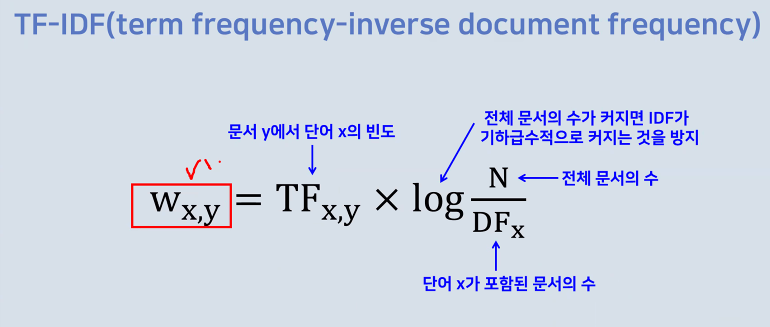
- 빨간 네모 박스 - 가중치

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer   # TF-IDF 객체
from konlpy.tag import Okt

In [11]:
# 샘플 데이터를 활용해서 TF-IDF를 파악해보자
# 벡터화 수행하기 전에 맛보기로 샘플데이터 생성!
sample_text = ["나는 오늘 점심에 삼계탕을 먹었다 왜", 
               "너 저녁에 운동갈꺼야?", 
               "나는 오늘 저녁에 운동하러 갈꺼야", 
               "좋겠다. 나는 저녁에 야간 자율 학습 하러 갈건데..."]

In [12]:
# TfIdf 객체 초기화
sample_tfidf = TfidfVectorizer()

In [13]:
# 단어사전 구축
sample_tfidf.fit(sample_text)

TfidfVectorizer()

In [14]:
# 단어사전 확인
sample_tfidf.vocabulary_

{'나는': 2,
 '오늘': 6,
 '점심에': 11,
 '삼계탕을': 4,
 '먹었다': 3,
 '저녁에': 10,
 '운동갈꺼야': 7,
 '운동하러': 8,
 '갈꺼야': 1,
 '좋겠다': 12,
 '야간': 5,
 '자율': 9,
 '학습': 14,
 '하러': 13,
 '갈건데': 0}

In [15]:
okt = Okt()

In [16]:
okt.morphs(sample_text[0])

['나', '는', '오늘', '점심', '에', '삼계탕', '을', '먹었다', '왜']

In [17]:
okt.pos(sample_text[0])

[('나', 'Noun'),
 ('는', 'Josa'),
 ('오늘', 'Noun'),
 ('점심', 'Noun'),
 ('에', 'Josa'),
 ('삼계탕', 'Noun'),
 ('을', 'Josa'),
 ('먹었다', 'Verb'),
 ('왜', 'Noun')]

In [18]:
# 명사만 추출!
okt.nouns(sample_text[0])

['나', '오늘', '점심', '삼계탕', '왜']

In [19]:
# BOW, TFIDF는 기본적으로 "공백" 기준으로 토큰화 수행됨
# 토큰의 단위를 형태소 분석기를 응용하여 설정

In [20]:
# 토큰화 도구 만들기(사용자 정의 함수)
def my_tokenizer(text) :     # 문장 형태가 나오면
    return okt.nouns(text)   # 명사만 뽑아내서 반환시켜주는 함수

In [21]:
tfidf_okt = TfidfVectorizer(tokenizer = my_tokenizer, token_pattern = None)   # 인자값 넣기(함수명만)

In [22]:
# 단어사전 구축
tfidf_okt.fit(sample_text)
# 위에서 token_pattern = None 써주면 원인 메세지 사라짐

TfidfVectorizer(token_pattern=None,
                tokenizer=<function my_tokenizer at 0x00000158E2476520>)

In [23]:
# 단어사전 확인
tfidf_okt.vocabulary_

{'나': 0,
 '오늘': 4,
 '점심': 9,
 '삼계탕': 2,
 '왜': 5,
 '너': 1,
 '저녁': 8,
 '운동': 6,
 '야간': 3,
 '자율': 7,
 '학습': 10}

In [24]:
sample_text

['나는 오늘 점심에 삼계탕을 먹었다 왜',
 '너 저녁에 운동갈꺼야?',
 '나는 오늘 저녁에 운동하러 갈꺼야',
 '좋겠다. 나는 저녁에 야간 자율 학습 하러 갈건데...']

In [25]:
# 각각의 키값과 values 값을 리스트 형태로 묶어주기
df = pd.DataFrame([tfidf_okt.vocabulary_.keys(), tfidf_okt.vocabulary_.values()]).T
df = df.sort_values(by = 1).set_index(1).T
# => 인덱스별로 정렬됨

pd.concat([df, pd.DataFrame(tfidf_okt.transform(sample_text).toarray())])
# concat에 이어붙일 객체 df 넣어주기
# => 단어사전들이 나타내는 가중치 값 - 가중치값은 단어가 많으면 많을 수록 정확해짐
# => 위의 sample_text랑 비교
# 첫 문장이랑 세 번째 문장 둘 다 "나"라는 단어가 있는데 첫 문장의 "나"가 세 번째 문장의 "나"보다 희소성(중요성)이 떨어진다는 걸 알 수 있음

,0,1,2,3,4,5,6,7,8,9,10
0,나,너,삼계탕,야간,오늘,왜,운동,자율,저녁,점심,학습
0,0.317993,0.0,0.498197,0.0,0.392784,0.498197,0.0,0.0,0.0,0.498197,0.0
1,0.0,0.702035,0.0,0.0,0.0,0.0,0.553492,0.0,0.4481,0.0,0.0
2,0.444931,0.0,0.0,0.0,0.549578,0.0,0.549578,0.0,0.444931,0.0,0.0
3,0.326798,0.0,0.0,0.511992,0.0,0.0,0.0,0.511992,0.326798,0.0,0.511992


#### 실제 데이터에 적용하기

In [26]:
text_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 149995 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        149995 non-null  int64 
 1   document  149995 non-null  object
 2   label     149995 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.6+ MB


In [27]:
# 데이터 나누기(문제와 답 나누기)
X_train = text_train['document']
X_test = text_test['document']
y_train = text_train['label']
y_test = text_test['label']

In [28]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape
# => X 데이터는 1차원 리스트의 데이터형임

((149995,), (49997,), (149995,), (49997,))

- tfidf + okt 활용해서 토큰화
- LogisticRegression 모델 사용해서 모델링 분석 수행
- pipepine 기능 연결

In [29]:
from sklearn.pipeline import make_pipeline   # 기능 연결 도구
from sklearn.linear_model import LogisticRegression   # 선형 분류 모델 불러오기

In [30]:
pipe_model = make_pipeline(
    TfidfVectorizer(tokenizer = my_tokenizer,   # 사용자 정의 토크나이저 지정
                   token_pattern = None,        # 기본 세팅 제거
                   ngram_range = (1, 2)),       # 1-gram, 2-gram을 단어사전으로 채탣
    LogisticRegression(max_iter = 10000)     
)

In [31]:
# 데이터 개수 낮추기(슬라이싱 - 컬럼기호 사용하기)
# 데이터가 너무 커서 임의로 잘라옴
X_train = X_train[:10000]
X_test = X_test[:10000]
y_train = y_train[:10000]
y_test = y_test[:10000]

In [32]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10000,), (10000,), (10000,), (10000,))

In [33]:
# 약 1만개 가량 데이터를 벡터화를 수행하고 학습!
pipe_model.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(ngram_range=(1, 2), token_pattern=None,
                                 tokenizer=<function my_tokenizer at 0x00000158E2476520>)),
                ('logisticregression', LogisticRegression(max_iter=10000))])

In [34]:
# 평가(이진분류 - 정확도(73.91%))
pipe_model.score(X_test, y_test)

0.7391

In [35]:
# 예측/수행하기
pipe_model.predict(['이 영화 너무 재밌는 거 같아요!'])
# => 1 : 긍정

array([1], dtype=int64)

In [36]:
pipe_model.predict(['노잼'])

array([0], dtype=int64)

#### 긍정/부정에 영향을 끼친 단어 살펴보기

In [37]:
# 토큰화 도구에 접근
tfidf = pipe_model.steps[0][1]

# 모델 접근
logi = pipe_model.steps[1][1]

In [38]:
df = pd.DataFrame([tfidf.vocabulary_.keys(), tfidf.vocabulary_.values()]).T
df.columns = ["단어", "인덱스"]

In [39]:
df.sort_values(by="인덱스", inplace=True)

In [40]:
logi.coef_[0]

array([ 0.11604795,  0.11604795, -0.07471306, ...,  0.04927049,
        0.21707046,  0.12372123])

In [41]:
df["가중치"] = logi.coef_[0]   # 가중치값 추가, 2D array에서 인덱싱 수행해서 1D array로 컬럼 추가!

In [42]:
df.sort_values('가중치', inplace = True)
# => 가중치 오름차순으로 정렬
# => 가중치가 음수라는 것은 0에 가깝게끔 w값이 조정되어 있다는 것
# => 양수 쪽은 1, 즉 긍정에 영향을 준 것

In [43]:
df

,단어,인덱스,가중치
348,쓰레기,26702,-4.647901
915,최악,45207,-4.448393
443,돈,11209,-3.713564
275,별로,19063,-3.335169
853,뭐,16885,-3.146237
...,...,...,...
327,다시,9440,3.211627
307,꼭,6590,3.334176
1025,명작,15596,3.349194
172,감동,948,3.943067


In [44]:
bad = df.head(20)   # 부정(0)에 영향을 많이 끼친 상위 20ea 단어
good = df.tail(20)  # 긍정(1)에 영향을 많이 끼친 상위 20ea 단어

In [45]:
# bad와 good 병합 - concat() : 이어붙이기
top20 = pd.concat([bad, good])
top20

,단어,인덱스,가중치
348,쓰레기,26702,-4.647901
915,최악,45207,-4.448393
443,돈,11209,-3.713564
275,별로,19063,-3.335169
853,뭐,16885,-3.146237
844,실망,26280,-3.145392
531,감독,732,-2.704888
812,졸작,41443,-2.354766
4541,점도,39755,-2.229060
350,시간,25505,-2.203154


In [46]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'  # 한글이 지원되는 폰트로 설정
plt.rcParams['axes.unicode_minus'] = False     # 마이너스 기호를 사용하겠다

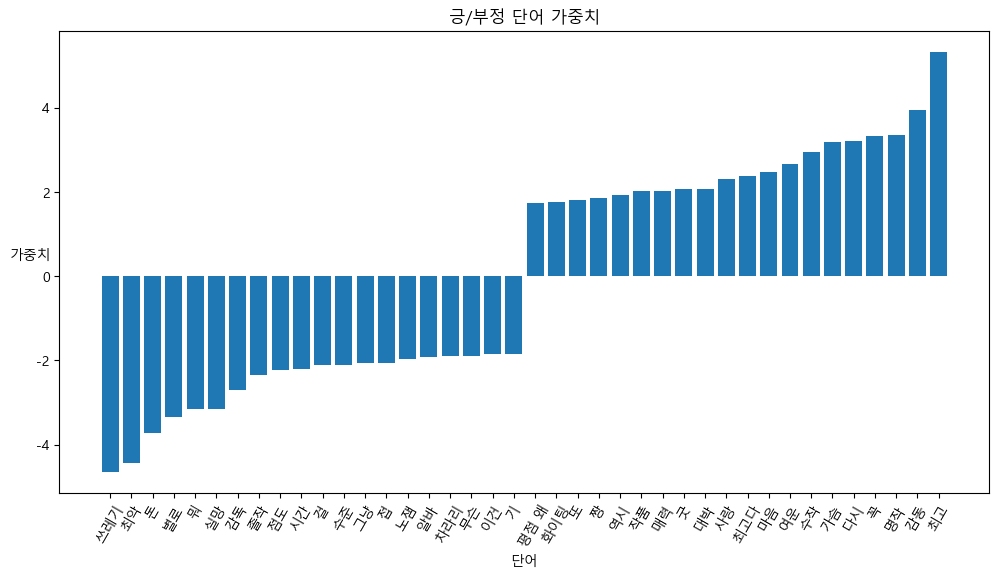

In [47]:
plt.figure(figsize = (12, 6))
plt.title("긍/부정 단어 가중치")
plt.xlabel("단어")
plt.ylabel("가중치", rotation = 0)   # rotation = 0 : 90도가 기본값
plt.bar(top20["단어"], top20["가중치"])
plt.xticks(rotation = 60)   # x축 "단어"라는 글자들 겹치지 않게 기울이기
plt.show()